In [1]:
import torch
import clip
from PIL import Image
import os
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt


In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# COCO dataset paths
COCO_IMAGE_FOLDER = r"D:\VS_Jnotepad_code\Search Enginer Project\coco_dataset\train2017_subset"
COCO_ANNOTATIONS_FILE = r"D:\VS_Jnotepad_code\Search Enginer Project\coco_dataset\annotations\annotations\captions_train2017.json"

In [3]:

# Load COCO captions
def load_coco_captions(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    image_id_to_captions = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        caption = ann['caption']
        if image_id not in image_id_to_captions:
            image_id_to_captions[image_id] = []
        image_id_to_captions[image_id].append(caption)
    return image_id_to_captions, data['images']

# Load embeddings
image_embeddings = pickle.load(open("coco_image_embeddings.pkl", "rb"))
text_embeddings = pickle.load(open("coco_text_embeddings.pkl", "rb"))

In [4]:
# Function to generate text embeddings
def get_text_embedding(query):
    text_tokenized = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_tokenized)
        text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
    return text_embedding.cpu().numpy()

# Function to perform semantic search
def search_images(query, top_k=5):
    text_embedding = get_text_embedding(query)
    image_filenames = list(image_embeddings.keys())
    image_vectors = np.array([image_embeddings[fname] for fname in image_filenames])
    
    # Compute cosine similarity
    similarities = np.dot(image_vectors, text_embedding.T).squeeze()
    
    # Get top matches
    top_indices = similarities.argsort()[-top_k:][::-1]
    top_images = [image_filenames[i] for i in top_indices]
    top_scores = [similarities[i] for i in top_indices]
    
    return top_images, top_scores


In [5]:
# Function to visualize search results
def display_results(query, top_k=5):
    top_images, top_scores = search_images(query, top_k)
    
    fig, axes = plt.subplots(1, top_k, figsize=(15,5))
    for i, (img_name, score) in enumerate(zip(top_images, top_scores)):
        img_path = os.path.join(COCO_IMAGE_FOLDER, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Score: {score:.2f}")
        axes[i].axis("off")
    
    plt.suptitle(f"Query: {query}")
    plt.show()

print("Search system is ready! Use display_results('your query') to search.")


Search system is ready! Use display_results('your query') to search.


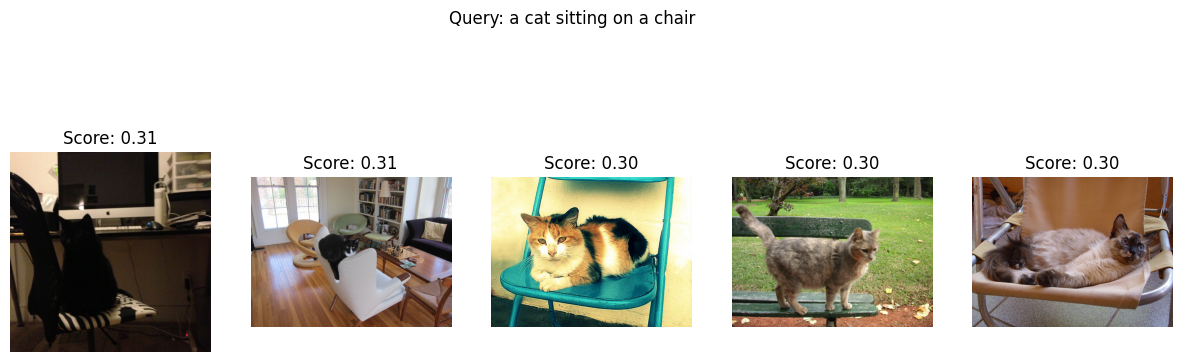

In [6]:
display_results("a cat sitting on a chair", top_k=5)